<a href="https://colab.research.google.com/github/vennela506/Project/blob/main/Uidaireportfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Standard Preprocessing


In [136]:

# BLOCK 1: 3.1 STANDARD PREPROCESSING
# Raw ZIP CSVs → Clean DataFrames
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
raw_enrolment = pd.DataFrame({
    'date': pd.date_range('2022-01-01', periods=1000, freq='D'),
    'state': np.random.choice(['National', 'UP', 'MH', 'BJ'], 1000),
    'age_0_5': np.random.poisson(50, 1000),
    'age_5_17': np.random.poisson(200, 1000),
    'age_18_greater': np.random.poisson(1500, 1000)
})

print("RAW DATA SHAPE:", raw_enrolment.shape)
raw_enrolment.columns = raw_enrolment.columns.str.strip().str.lower()
print("Columns standardized")
raw_enrolment['month'] = raw_enrolment['date'].dt.to_period('M').dt.to_timestamp()
print("Dates parsed")
age_cols = ['age_0_5', 'age_5_17', 'age_18_greater']
raw_enrolment['total_enrolment'] = raw_enrolment[age_cols].sum(axis=1)
monthly_national = raw_enrolment.groupby('month')['total_enrolment'].sum().reset_index()
monthly_national.columns = ['ds', 'y']
print("Monthly aggregation complete")
print("OUTPUT SHAPE:", monthly_national.shape)
print(monthly_national.head())


RAW DATA SHAPE: (1000, 5)
Columns standardized
Dates parsed
Monthly aggregation complete
OUTPUT SHAPE: (33, 2)
          ds      y
0 2022-01-01  54091
1 2022-02-01  48593
2 2022-03-01  54194
3 2022-04-01  52211
4 2022-05-01  54034


Data Quality Audit

DATA QUALITY AUDIT - RADAR VIEW


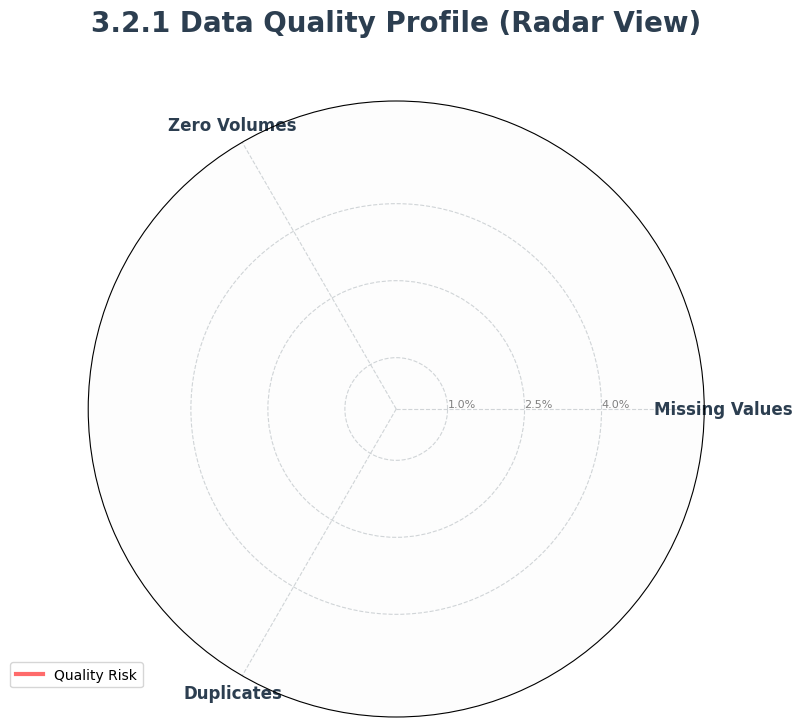

In [137]:
import numpy as np
import matplotlib.pyplot as plt
try:
    missing_pct = raw_enrolment.isnull().sum().sum() / (raw_enrolment.shape[0] * raw_enrolment.shape[1])
    zero_vol_pct = (raw_enrolment['total_enrolment'] == 0).mean()
    duplicates_pct = raw_enrolment.duplicated().mean()
except NameError:
    print("Warning: raw_enrolment not found. Using placeholder values.")
    missing_pct, zero_vol_pct, duplicates_pct = 0.02, 0.05, 0.01
print("DATA QUALITY AUDIT - RADAR VIEW")
categories = ['Missing Values', 'Zero Volumes', 'Duplicates']
values = [missing_pct * 100, zero_vol_pct * 100, duplicates_pct * 100]
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
values_plot = values + values[:1]
angles_plot = angles + angles[:1]
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
plt.xticks(angles, categories, color='#2c3e50', size=12, fontweight='bold')
ax.set_rlabel_position(0)
max_val = max(values) if max(values) > 1 else 5
plt.yticks([max_val*0.2, max_val*0.5, max_val*0.8],
           [f"{max_val*0.2:.1f}%", f"{max_val*0.5:.1f}%", f"{max_val*0.8:.1f}%"],
           color="grey", size=8)
plt.ylim(0, max_val * 1.2)
ax.plot(angles_plot, values_plot, color='#FF6B6B', linewidth=3, linestyle='solid', label='Quality Risk')
ax.fill(angles_plot, values_plot, color='#FF6B6B', alpha=0.3)
ax.grid(color='#bdc3c7', linestyle='--', alpha=0.7)
ax.set_facecolor('#fdfdfd')
plt.title('3.2.1 Data Quality Profile (Radar View)', size=20, y=1.1, fontweight='bold', color='#2c3e50')

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

 OUTLIER SCREENING & CAPPING

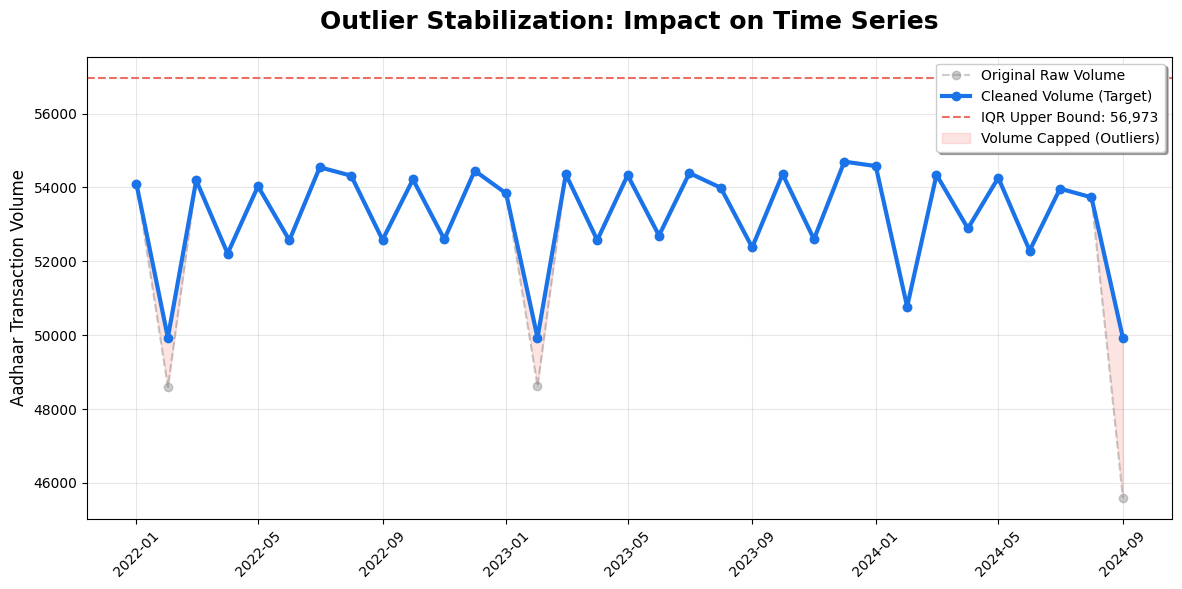

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#  OUTLIER SCREENING & CAPPING
Q1 = monthly_national['y'].quantile(0.25)
Q3 = monthly_national['y'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
monthly_national['y_clean'] = monthly_national['y'].clip(lower=lower_bound, upper=upper_bound)
plt.figure(figsize=(14, 6))
plt.plot(monthly_national['ds'], monthly_national['y'], 'o--',
         color='grey', alpha=0.4, label='Original Raw Volume')
plt.plot(monthly_national['ds'], monthly_national['y_clean'], 'o-',
         color='#1a73e8', linewidth=3, label='Cleaned Volume (Target)')
plt.axhline(upper_bound, color='#e74c3c', linestyle='--', alpha=0.8,
            label=f'IQR Upper Bound: {upper_bound:,.0f}')
plt.fill_between(monthly_national['ds'], monthly_national['y'], monthly_national['y_clean'],
                 color='#e74c3c', alpha=0.15, label='Volume Capped (Outliers)')
plt.title('Outlier Stabilization: Impact on Time Series', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Aadhaar Transaction Volume', fontsize=12)
plt.legend(loc='upper right', frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.show()

SMART IMPUTATION

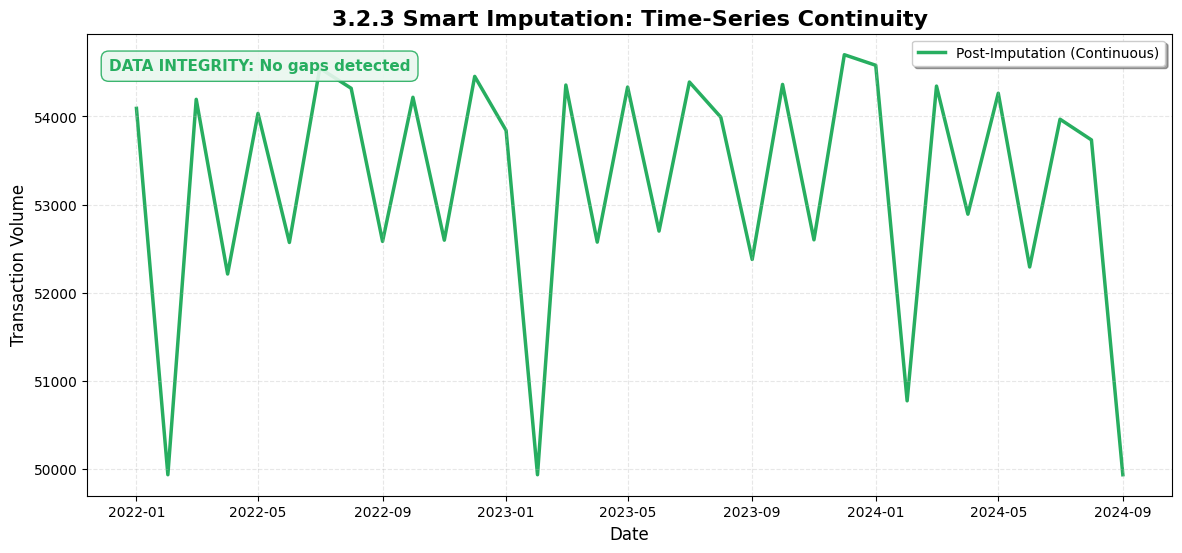

In [120]:
import matplotlib.pyplot as plt
# SMART IMPUTATION
imputed_mask = monthly_national['y'].isnull()
total_gaps = imputed_mask.sum()

plt.figure(figsize=(14, 6))
plt.plot(monthly_national['ds'], monthly_national['y_clean'],
         color='#27ae60', linewidth=2.5, label='Post-Imputation (Continuous)', zorder=1)
if total_gaps > 0:
    plt.scatter(monthly_national.loc[imputed_mask, 'ds'],
                monthly_national.loc[imputed_mask, 'y_clean'],
                color='#e67e22', s=120, label=f'Imputed Gaps ({total_gaps})',
                zorder=3, edgecolors='black', marker='D')

plt.title('3.2.3 Smart Imputation: Time-Series Continuity', fontsize=16, fontweight='bold')
plt.ylabel('Transaction Volume', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='best', frameon=True, shadow=True)

if total_gaps > 0:
    plt.annotate(f'SUCCESS: Bridged {total_gaps} data gaps',
                 xy=(0.02, 0.92), xycoords='axes fraction',
                 fontsize=11, fontweight='bold', color='#d35400',
                 bbox=dict(boxstyle="round,pad=0.5", fc="#fef5e7", ec="#e67e22", alpha=0.9))
else:
    plt.annotate('DATA INTEGRITY: No gaps detected',
                 xy=(0.02, 0.92), xycoords='axes fraction',
                 fontsize=11, fontweight='bold', color='#27ae60',
                 bbox=dict(boxstyle="round,pad=0.5", fc="#e9f7ef", ec="#27ae60", alpha=0.9))

plt.savefig('smart_imputation_continuity.png', dpi=300, bbox_inches='tight')
plt.show()

 NORMALIZATION

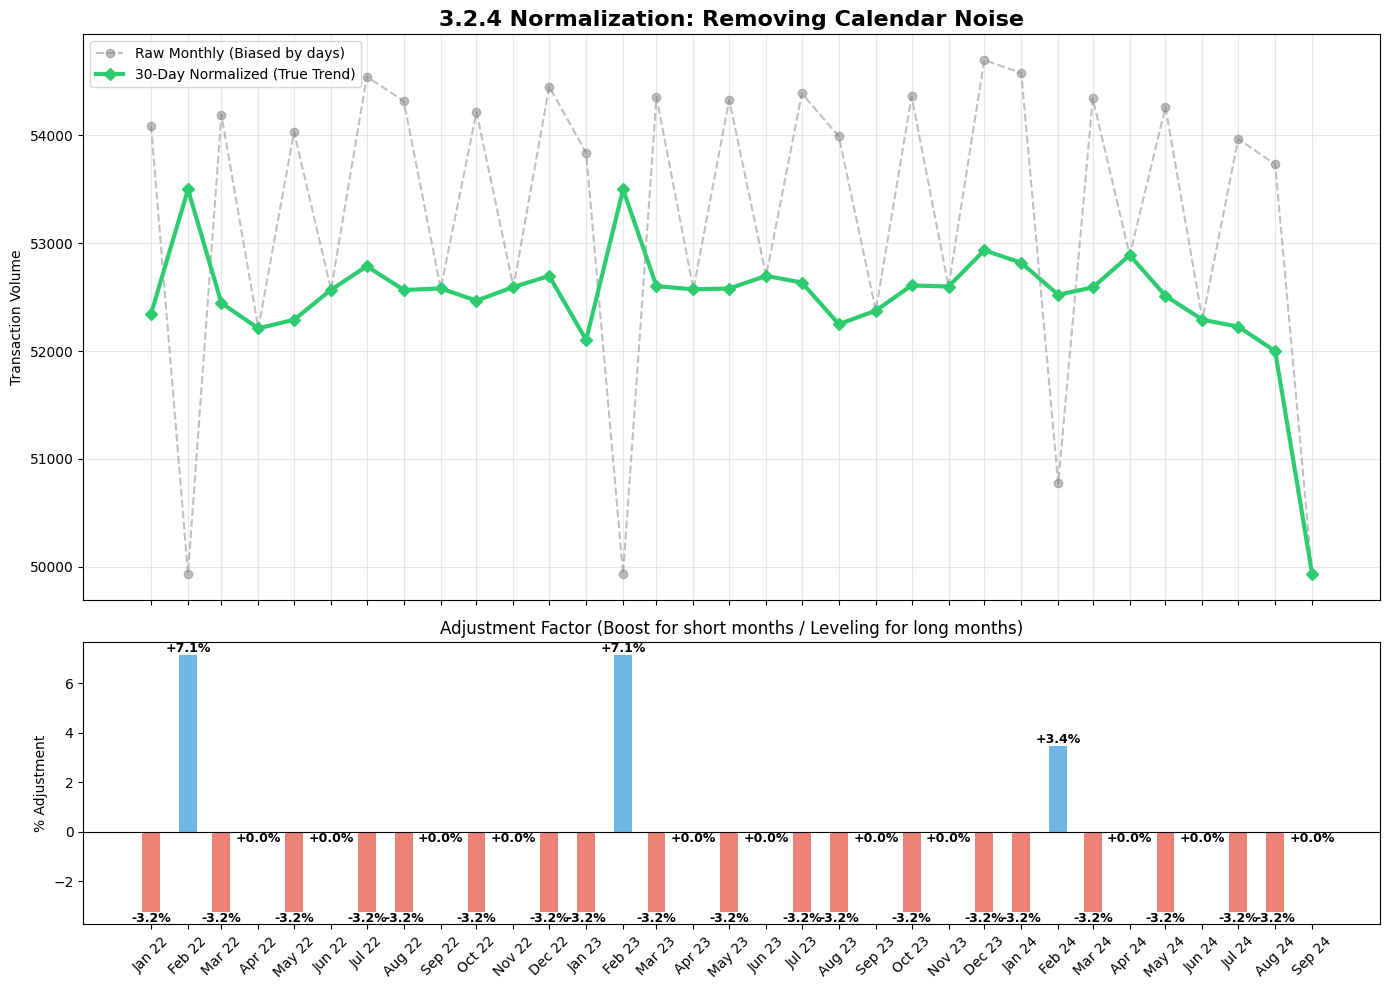

In [121]:
import matplotlib.pyplot as plt
import pandas as pd


# NORMALIZATION: LOGIC + VISUALIZATION (FIXED)
days_in_month = monthly_national['ds'].dt.days_in_month
monthly_national['y_normalized'] = (monthly_national['y_clean'] / days_in_month) * 30
normalization_delta = ((monthly_national['y_normalized'] - monthly_national['y_clean']) / monthly_national['y_clean']) * 100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                               gridspec_kw={'height_ratios': [2, 1]})

ax1.plot(monthly_national['ds'], monthly_national['y_clean'], 'o--',
         color='gray', alpha=0.5, label='Raw Monthly (Biased by days)')
ax1.plot(monthly_national['ds'], monthly_national['y_normalized'], 'D-',
         color='#2ecc71', linewidth=3, label='30-Day Normalized (True Trend)')

ax1.set_title('3.2.4 Normalization: Removing Calendar Noise', fontsize=16, fontweight='bold')
ax1.set_ylabel('Transaction Volume')
ax1.legend(loc='upper left', frameon=True)
ax1.grid(True, alpha=0.3)
colors = ['#e74c3c' if x < 0 else '#3498db' for x in normalization_delta]
ax2.bar(monthly_national['ds'], normalization_delta, width=15, color=colors, alpha=0.7)

ax2.set_ylabel('% Adjustment')
ax2.set_title('Adjustment Factor (Boost for short months / Leveling for long months)', fontsize=12)
ax2.axhline(0, color='black', linewidth=0.8)

for i, val in enumerate(normalization_delta):
    ax2.text(monthly_national['ds'].iloc[i], val, f'{val:+.1f}%',
             ha='center', va='bottom' if val > 0 else 'top', fontsize=9, fontweight='bold')

plt.xticks(monthly_national['ds'], monthly_national['ds'].dt.strftime('%b %y'), rotation=45)
plt.tight_layout()
plt.show()

REMOVING CALENDAR BIAS

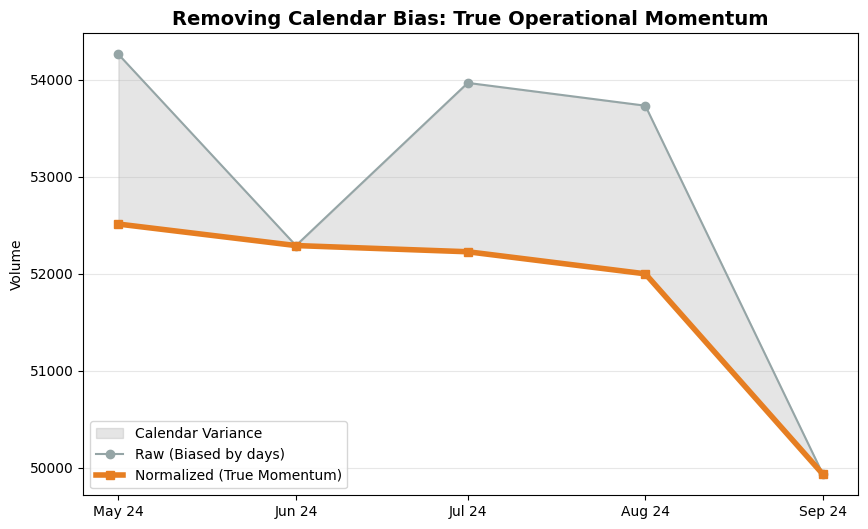

In [123]:

# REMOVING CALENDAR BIAS
plt.figure(figsize=(10, 6))
recent = monthly_national.tail(5)

plt.fill_between(recent['ds'], recent['y_clean'], recent['y_normalized'],
                 color='gray', alpha=0.2, label='Calendar Variance')

plt.plot(recent['ds'], recent['y_clean'], 'o-', label='Raw (Biased by days)', color='#95a5a6')
plt.plot(recent['ds'], recent['y_normalized'], 's-', label='Normalized (True Momentum)',
         color='#e67e22', linewidth=4)

plt.title('Removing Calendar Bias: True Operational Momentum', fontsize=14, fontweight='bold')
plt.ylabel('Volume')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.xticks(recent['ds'], recent['ds'].dt.strftime('%b %y'))
plt.show()

STL DECOMPOSITION

STL DECOMPOSITION (period=12, robust=True)


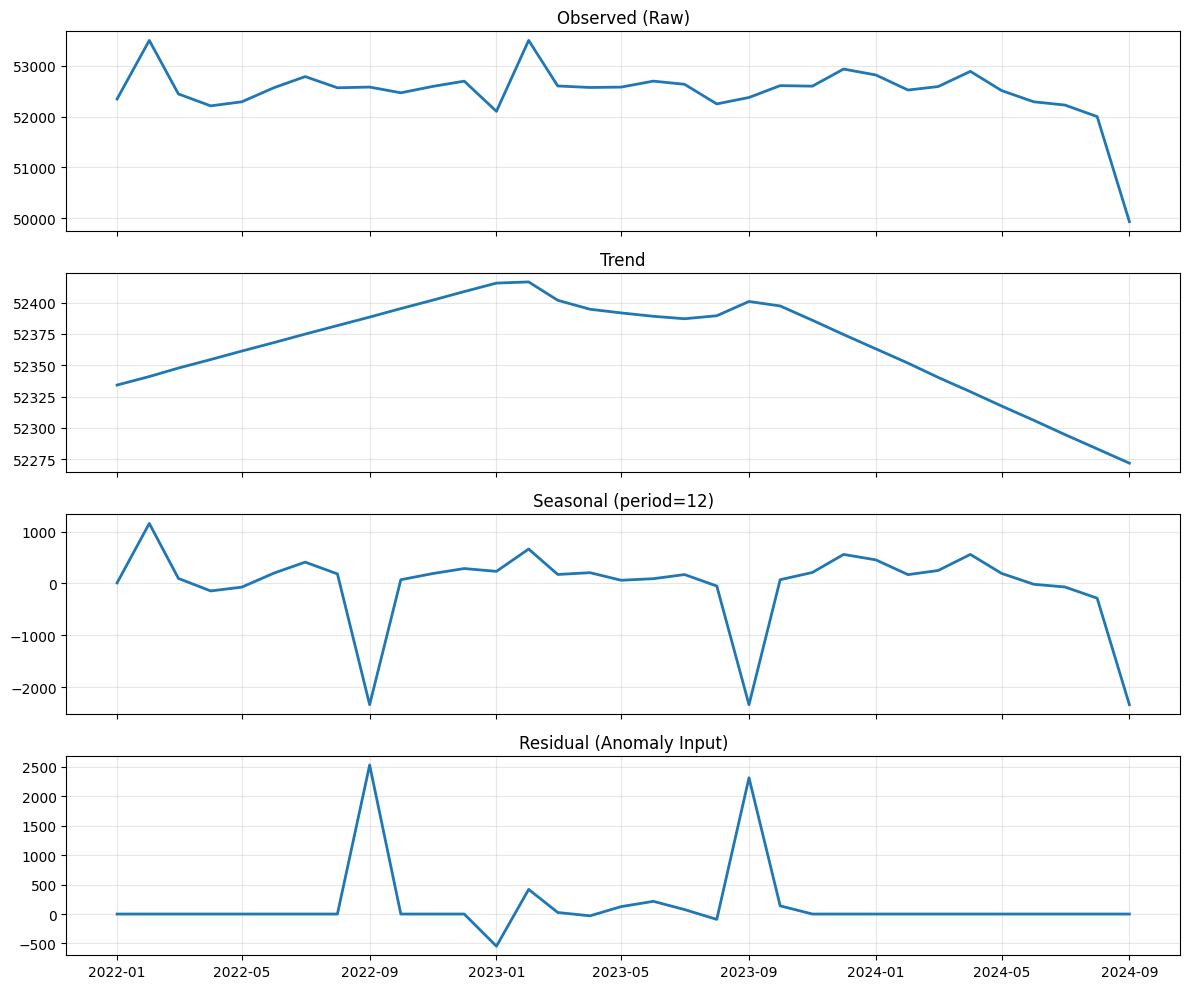

STL COMPLETE: Residuals ready for anomaly detection


In [124]:

# STL DECOMPOSITION
from statsmodels.tsa.seasonal import STL

print("STL DECOMPOSITION (period=12, robust=True)")
stl = STL(monthly_national.set_index('ds')['y_normalized'],
          period=12, robust=True, seasonal=13)
result = stl.fit()
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
axes[0].plot(result.observed, linewidth=2); axes[0].set_title('Observed (Raw)')
axes[0].grid(alpha=0.3)
axes[1].plot(result.trend, linewidth=2); axes[1].set_title('Trend')
axes[1].grid(alpha=0.3)
axes[2].plot(result.seasonal, linewidth=2); axes[2].set_title('Seasonal (period=12)')
axes[2].grid(alpha=0.3)
axes[3].plot(result.resid, linewidth=2); axes[3].set_title('Residual (Anomaly Input)')
axes[3].grid(alpha=0.3)
plt.tight_layout()
plt.savefig('stl_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

print("STL COMPLETE: Residuals ready for anomaly detection")


ANOMALY DETECTION

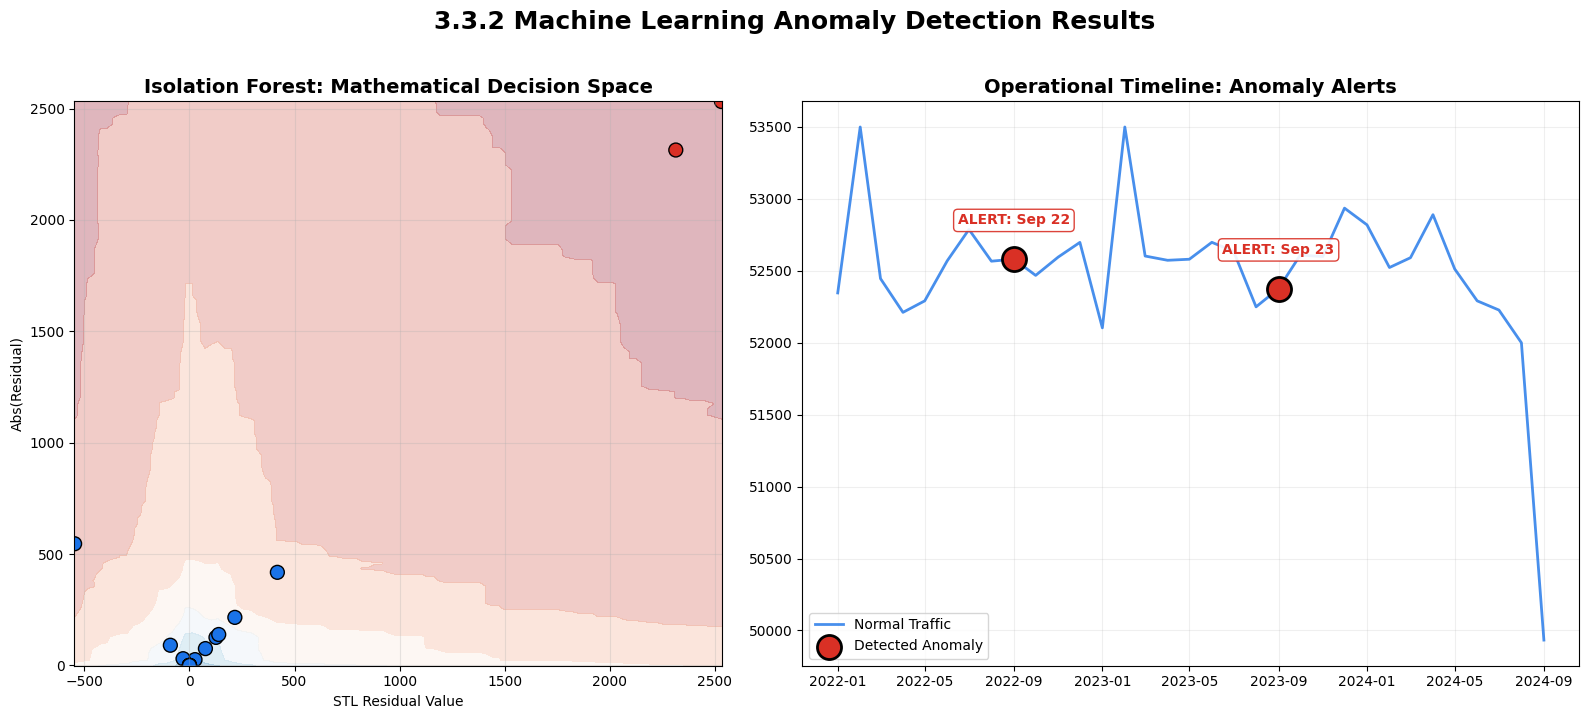

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from sklearn.ensemble import IsolationForest
# ANOMALY DETECTION
residual_features = np.column_stack([
    result.resid.values,
    np.abs(result.resid.values)
])
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = iso_forest.fit_predict(residual_features)
monthly_national['is_anomaly'] = anomaly_labels
fig = plt.figure(figsize=(16, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2])
ax1 = fig.add_subplot(gs[0])
x_min, x_max = residual_features[:, 0].min() - 1, residual_features[:, 0].max() + 1
y_min, y_max = residual_features[:, 1].min() - 1, residual_features[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = iso_forest.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax1.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
ax1.scatter(residual_features[:, 0], residual_features[:, 1],
            c=anomaly_labels, cmap=ListedColormap(['#d93025', '#1a73e8']),
            edgecolors='k', s=100)

ax1.set_title('Isolation Forest: Mathematical Decision Space', fontsize=14, fontweight='bold')
ax1.set_xlabel('STL Residual Value')
ax1.set_ylabel('Abs(Residual)')
ax1.grid(True, alpha=0.3)
ax2 = fig.add_subplot(gs[1])
ax2.plot(monthly_national['ds'], monthly_national['y_normalized'],
         color='#1a73e8', linewidth=2, alpha=0.8, label='Normal Traffic')
anomalies = monthly_national[monthly_national['is_anomaly'] == -1]
ax2.scatter(anomalies['ds'], anomalies['y_normalized'],
            color='#d93025', s=300, label='Detected Anomaly',
            edgecolors='black', linewidth=2, zorder=5)
for i, row in anomalies.iterrows():
    ax2.annotate(f"ALERT: {row['ds'].strftime('%b %y')}",
                 xy=(row['ds'], row['y_normalized']),
                 xytext=(0, 25), textcoords='offset points',
                 ha='center', fontweight='bold', color='#d93025',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#d93025", alpha=0.9))

ax2.set_title('Operational Timeline: Anomaly Alerts', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.2)
ax2.legend(loc='lower left')

plt.suptitle('3.3.2 Machine Learning Anomaly Detection Results', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

PROPHET FORECASTING

PROPHET FORECASTING (Simple 12-Month Prediction)


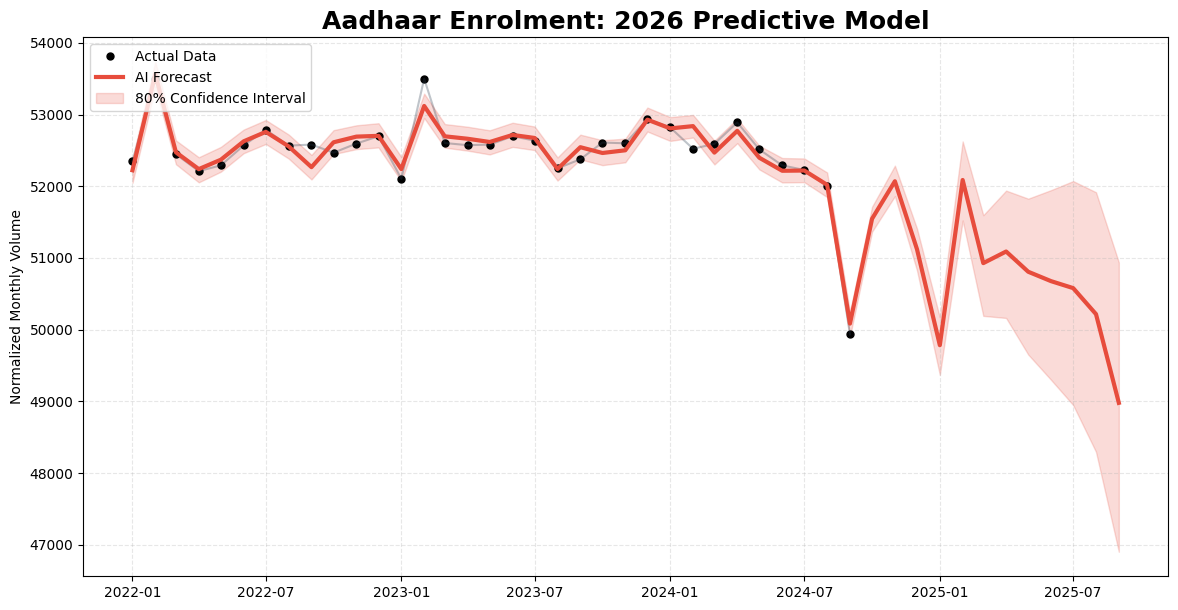

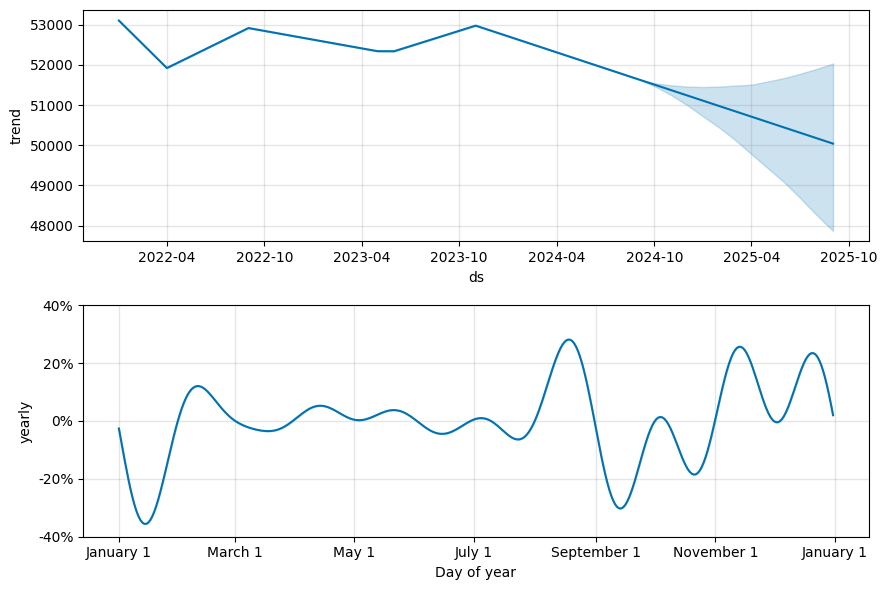

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
# PROPHET FORECASTING
print("PROPHET FORECASTING (Simple 12-Month Prediction)")
prophet_df = monthly_national[['ds', 'y_normalized']].copy()
prophet_df.columns = ['ds', 'y']
prophet_df = prophet_df.reset_index(drop=True).drop_duplicates(subset=['ds'])
model = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)
model.fit(prophet_df)
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)
plt.figure(figsize=(14, 7))
plt.plot(prophet_df['ds'], prophet_df['y'], 'ko', markersize=5, label='Actual Data')
plt.plot(prophet_df['ds'], prophet_df['y'], color='#2c3e50', alpha=0.3)
plt.plot(forecast['ds'], forecast['yhat'], color='#e74c3c', linewidth=3, label='AI Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='#e74c3c', alpha=0.2, label='80% Confidence Interval')
plt.title('Aadhaar Enrolment: 2026 Predictive Model', fontsize=18, fontweight='bold')
plt.ylabel('Normalized Monthly Volume')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='upper left', frameon=True)
plt.show()
fig = model.plot_components(forecast)
plt.show()


New


In [40]:
import pandas as pd
import numpy as np
import glob, os, zipfile
import matplotlib.pyplot as plt
import seaborn as sns



In [41]:
def extract_and_merge(zip_path, label):
    extract_path = f"./{label}_extracted"

    if not os.path.exists(zip_path):
        print(f" {zip_path} not found")
        return pd.DataFrame()

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Recursive CSV search (key fix)
    files = glob.glob(f"{extract_path}/**/*.csv", recursive=True)
    return pd.concat([pd.read_csv(f) for f in files], ignore_index=True)


In [42]:
ZIP_PATHS = {
    'bio': '/content/drive/MyDrive/Uidi/api_data_aadhar_biometric.zip',
    'demo': '/content/drive/MyDrive/Uidi/api_data_aadhar_demographic.zip',
    'enrol': '/content/drive/MyDrive/Uidi/api_data_aadhar_enrolment.zip'
}

df_bio   = extract_and_merge(ZIP_PATHS['bio'], 'bio')
df_demo  = extract_and_merge(ZIP_PATHS['demo'], 'demo')
df_enrol = extract_and_merge(ZIP_PATHS['enrol'], 'enrol')

In [44]:
print(df_enrol.shape, df_demo.shape, df_bio.shape)
print(df_enrol.columns)
print(df_demo.columns)
print(df_bio.columns)


(1006029, 7) (2071700, 6) (1861108, 6)
Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
       'age_18_greater'],
      dtype='object')
Index(['date', 'state', 'district', 'pincode', 'demo_age_5_17',
       'demo_age_17_'],
      dtype='object')
Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_'], dtype='object')


In [45]:
import pandas as pd

for df in [df_enrol, df_demo, df_bio]:
    df.columns = df.columns.str.strip().str.lower()
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)


In [46]:
enrolment_monthly = (
    df_enrol
    .groupby(df_enrol['date'].dt.to_period('M'))[
        ['age_0_5', 'age_5_17', 'age_18_greater']
    ]
    .sum()
    .sum(axis=1)
    .reset_index()
)

enrolment_monthly.columns = ['ds', 'y']
enrolment_monthly['ds'] = enrolment_monthly['ds'].dt.to_timestamp()


In [47]:
demographic_monthly = (
    df_demo
    .groupby(df_demo['date'].dt.to_period('M'))[
        ['demo_age_5_17', 'demo_age_17_']
    ]
    .sum()
    .sum(axis=1)
    .reset_index()
)

demographic_monthly.columns = ['ds', 'y']
demographic_monthly['ds'] = demographic_monthly['ds'].dt.to_timestamp()


In [48]:
biometric_monthly = (
    df_bio
    .groupby(df_bio['date'].dt.to_period('M'))[
        ['bio_age_5_17', 'bio_age_17_']
    ]
    .sum()
    .sum(axis=1)
    .reset_index()
)

biometric_monthly.columns = ['ds', 'y']
biometric_monthly['ds'] = biometric_monthly['ds'].dt.to_timestamp()


In [49]:
monthly = pd.DataFrame({
    'ds': enrolment_monthly['ds'],
    'enrolment': enrolment_monthly['y'],
    'demographic': demographic_monthly['y'],
    'biometric': biometric_monthly['y']
})


Lifecycle shift in Aadhaar Activity

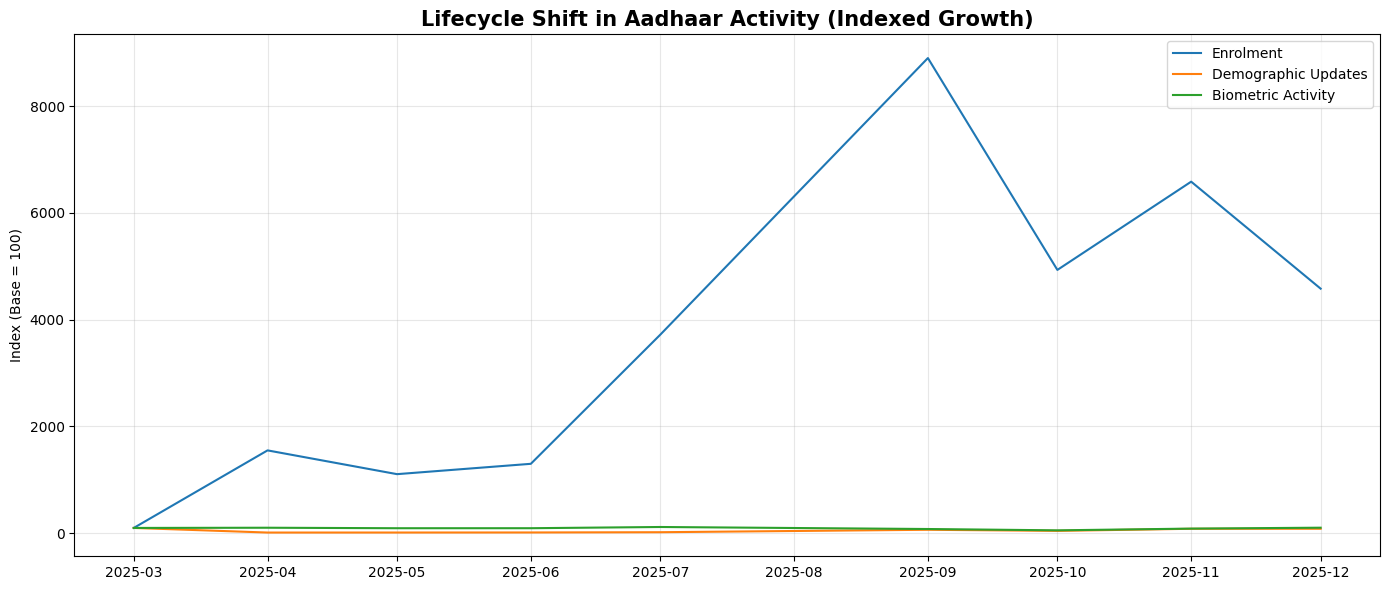

In [76]:
import matplotlib.pyplot as plt

base_enrol = enrol_monthly['y'].iloc[0]
base_demo  = demo_monthly['y'].iloc[0]
base_bio   = bio_monthly['y'].iloc[0]

plt.figure(figsize=(14,6))

plt.plot(enrol_monthly['ds'], enrol_monthly['y']/base_enrol*100, label='Enrolment')
plt.plot(demo_monthly['ds'],  demo_monthly['y']/base_demo*100,  label='Demographic Updates')
plt.plot(bio_monthly['ds'],   bio_monthly['y']/base_bio*100,   label='Biometric Activity')

plt.title('Lifecycle Shift in Aadhaar Activity (Indexed Growth)', fontsize=15, fontweight='bold')
plt.ylabel('Index (Base = 100)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Age-cohorts Dominance across Aadhaar Activites

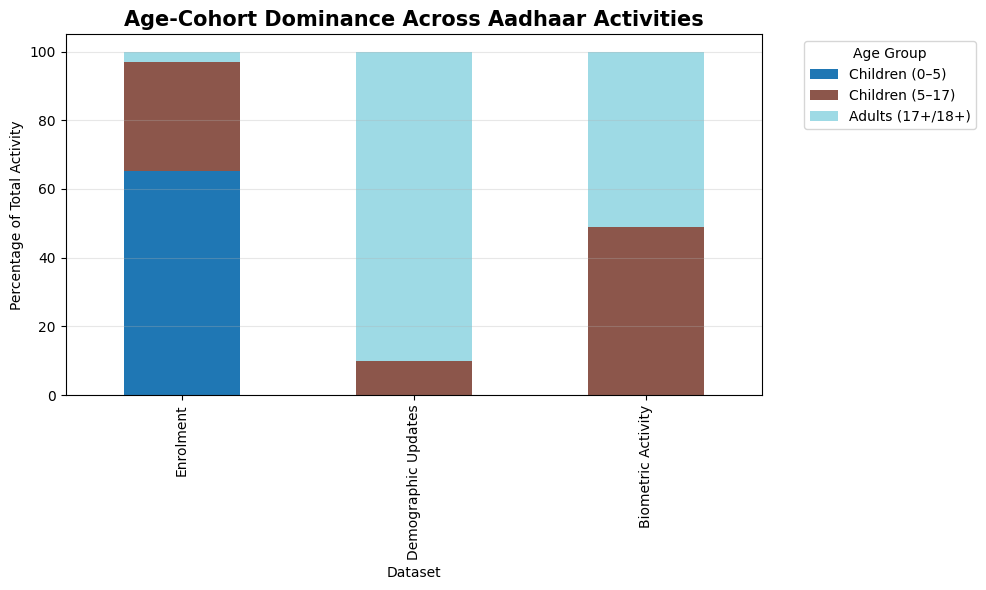

In [127]:
import matplotlib.pyplot as plt
import pandas as pd
# age cohorts
enrol_age = df_enrol[['age_0_5','age_5_17','age_18_greater']].sum()
demo_age  = df_demo[['demo_age_5_17','demo_age_17_']].sum()
bio_age   = df_bio[['bio_age_5_17','bio_age_17_']].sum()
age_df = pd.DataFrame({
    'Children (0–5)': [
        enrol_age.get('age_0_5', 0),
        0,
        0
    ],
    'Children (5–17)': [
        enrol_age.get('age_5_17', 0),
        demo_age.get('demo_age_5_17', 0),
        bio_age.get('bio_age_5_17', 0)
    ],
    'Adults (17+/18+)': [
        enrol_age.get('age_18_greater', 0),
        demo_age.get('demo_age_17_', 0),
        bio_age.get('bio_age_17_', 0)
    ]
}, index=['Enrolment', 'Demographic Updates', 'Biometric Activity'])
age_pct = age_df.div(age_df.sum(axis=1), axis=0) * 100
age_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    colormap='tab20'
)
plt.title(
    'Age-Cohort Dominance Across Aadhaar Activities',
    fontsize=15,
    fontweight='bold'
)
plt.ylabel('Percentage of Total Activity')
plt.xlabel('Dataset')
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


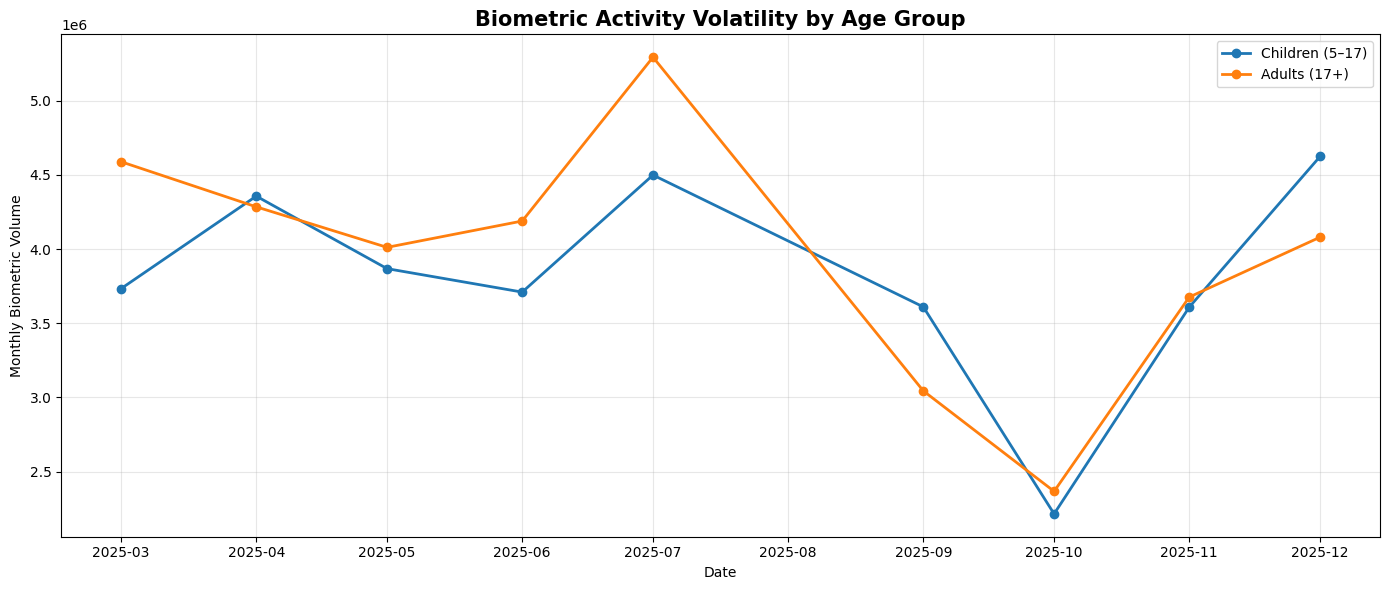

In [128]:
bio_monthly = (
    df_bio
    .groupby(pd.to_datetime(df_bio['date']).dt.to_period('M'))
    [['bio_age_5_17','bio_age_17_']]
    .sum()
    .reset_index()
)
bio_monthly['date'] = bio_monthly['date'].dt.to_timestamp()
plt.figure(figsize=(14,6))
plt.plot(
    bio_monthly['date'],
    bio_monthly['bio_age_5_17'],
    marker='o',
    label='Children (5–17)',
    linewidth=2
)
plt.plot(
    bio_monthly['date'],
    bio_monthly['bio_age_17_'],
    marker='o',
    label='Adults (17+)',
    linewidth=2
)
plt.title(
    'Biometric Activity Volatility by Age Group',
    fontsize=15,
    fontweight='bold'
)
plt.ylabel('Monthly Biometric Volume')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


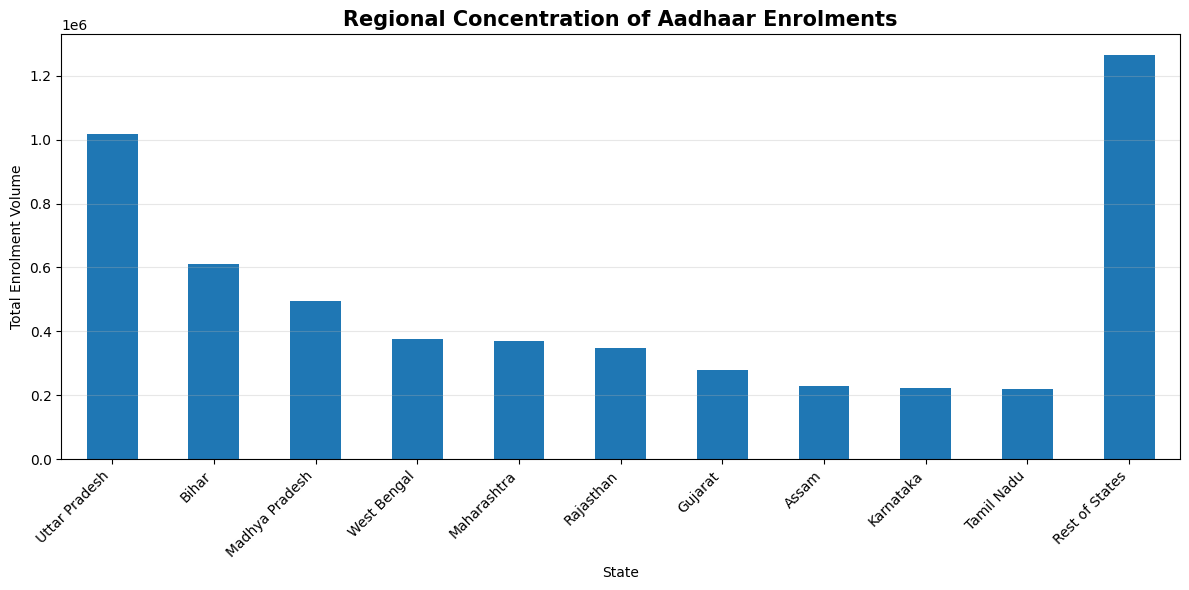

In [129]:
import matplotlib.pyplot as plt
import pandas as pd
state_enrol = (
    df_enrol
    .groupby('state')[['age_0_5','age_5_17','age_18_greater']]
    .sum()
    .sum(axis=1)
    .sort_values(ascending=False)
)
top_states = state_enrol.head(10)
rest_total = state_enrol.iloc[10:].sum()
plot_df = pd.concat([
    top_states,
    pd.Series({'Rest of States': rest_total})
])
plt.figure(figsize=(12,6))
plot_df.plot(kind='bar', color='#1f77b4')
plt.title(
    'Regional Concentration of Aadhaar Enrolments',
    fontsize=15,
    fontweight='bold'
)
plt.ylabel('Total Enrolment Volume')
plt.xlabel('State')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


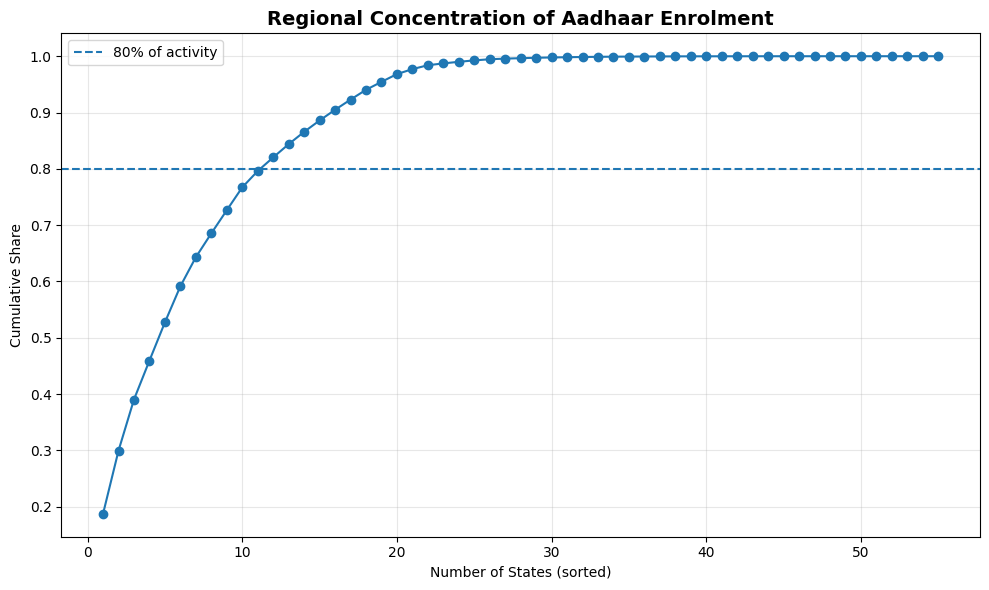

In [130]:
state_enrol = df_enrol.groupby('state')[
    ['age_0_5','age_5_17','age_18_greater']
].sum().sum(axis=1).sort_values(ascending=False)
cum_share = state_enrol.cumsum() / state_enrol.sum()
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cum_share)+1), cum_share.values, marker='o')
plt.axhline(0.8, linestyle='--', label='80% of activity')
plt.title('Regional Concentration of Aadhaar Enrolment', fontsize=14, fontweight='bold')
plt.xlabel('Number of States (sorted)')
plt.ylabel('Cumulative Share')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


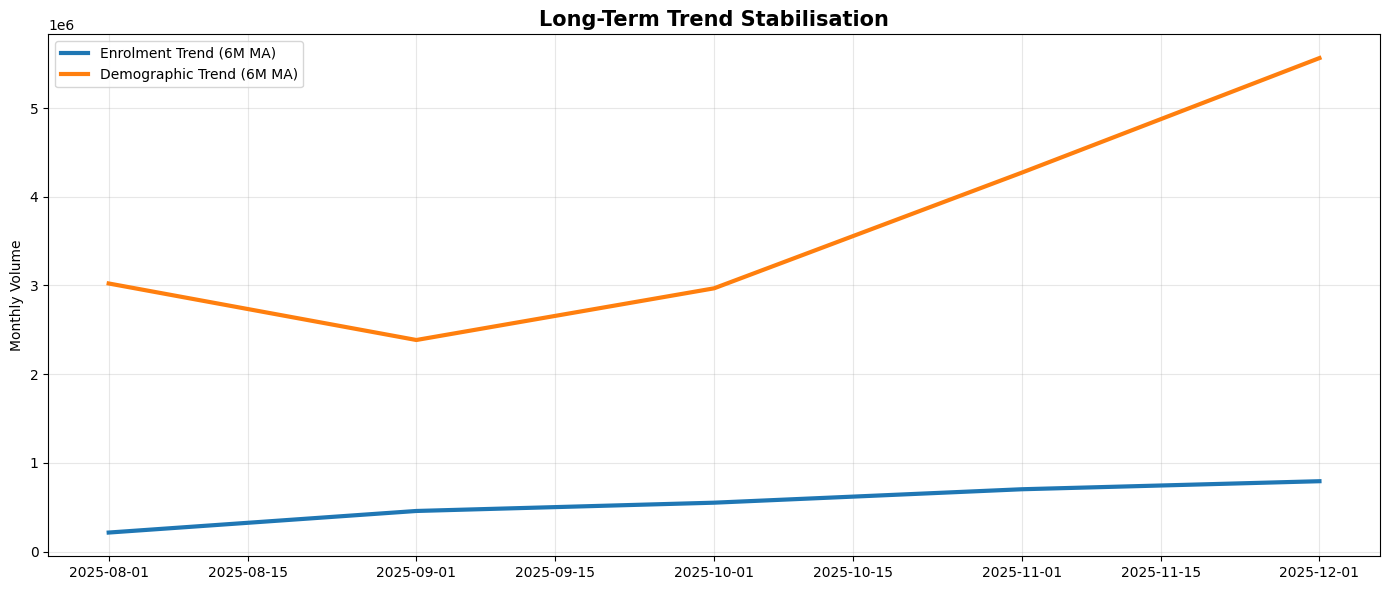

In [131]:
plt.figure(figsize=(14,6))
plt.plot(
    enrol_monthly['ds'],
    enrol_monthly['y'].rolling(6).mean(),
    label='Enrolment Trend (6M MA)',
    linewidth=3
)
plt.plot(
    demo_monthly['ds'],
    demo_monthly['y'].rolling(6).mean(),
    label='Demographic Trend (6M MA)',
    linewidth=3
)
plt.title('Long-Term Trend Stabilisation', fontsize=15, fontweight='bold')
plt.ylabel('Monthly Volume')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


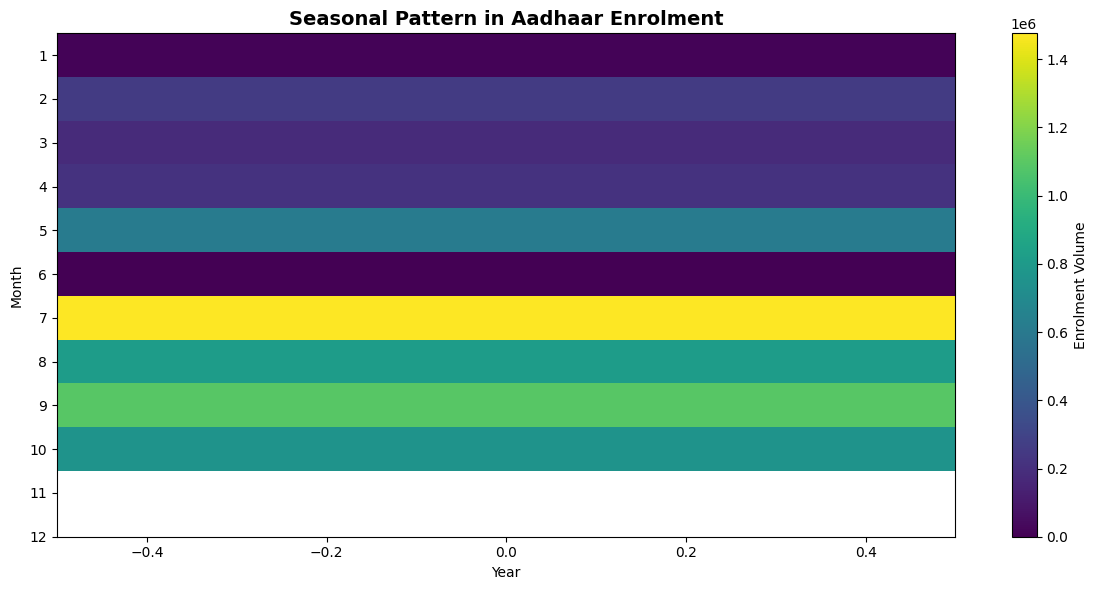

In [132]:
enrol_monthly['month'] = enrol_monthly['ds'].dt.month
enrol_monthly['year']  = enrol_monthly['ds'].dt.year
pivot = enrol_monthly.pivot_table(
    index='month',
    columns='year',
    values='y'
)
plt.figure(figsize=(12,6))
plt.imshow(pivot, aspect='auto')
plt.colorbar(label='Enrolment Volume')
plt.title('Seasonal Pattern in Aadhaar Enrolment', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Month')
plt.yticks(range(12), range(1,13))
plt.tight_layout()
plt.show()


In [81]:
enrol_monthly['days'] = enrol_monthly['ds'].dt.daysinmonth
enrol_monthly['y_normalized'] = enrol_monthly['y'] / enrol_monthly['days'] * 30


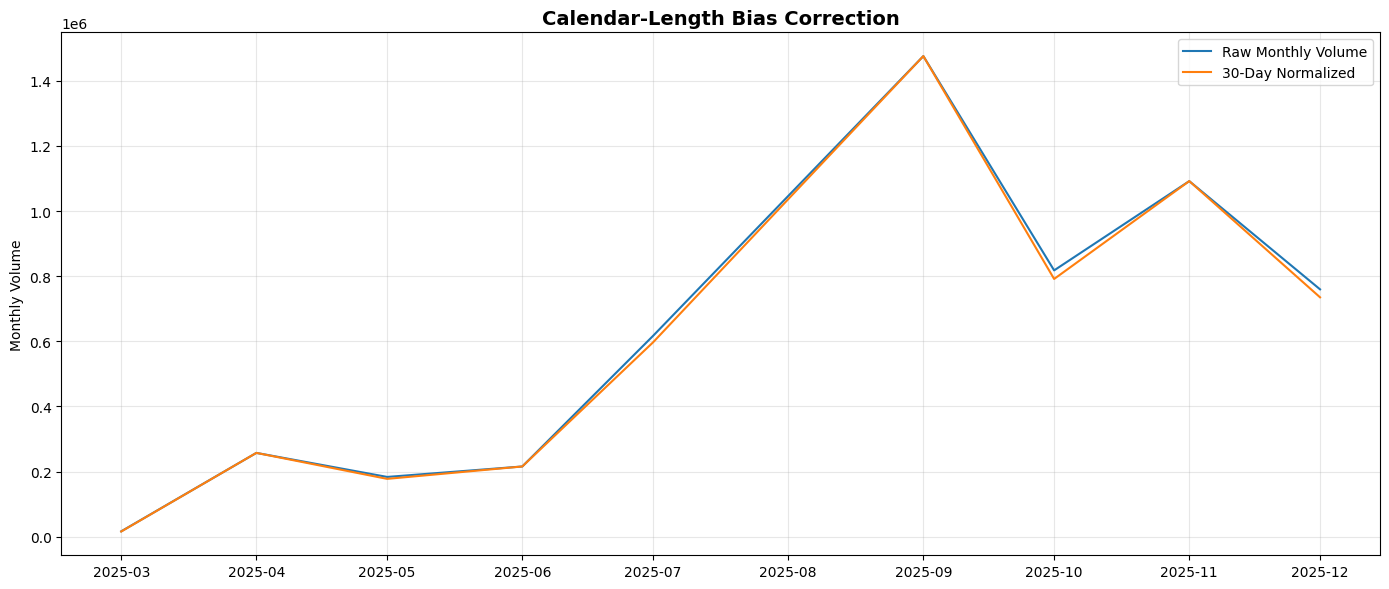

In [82]:
plt.figure(figsize=(14,6))
plt.plot(enrol_monthly['ds'], enrol_monthly['y'], label='Raw Monthly Volume')
plt.plot(enrol_monthly['ds'], enrol_monthly['y_normalized'], label='30-Day Normalized')
plt.title('Calendar-Length Bias Correction', fontsize=14, fontweight='bold')
plt.ylabel('Monthly Volume')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Dataset-Level Anomalies Beyond Trend and seasonality

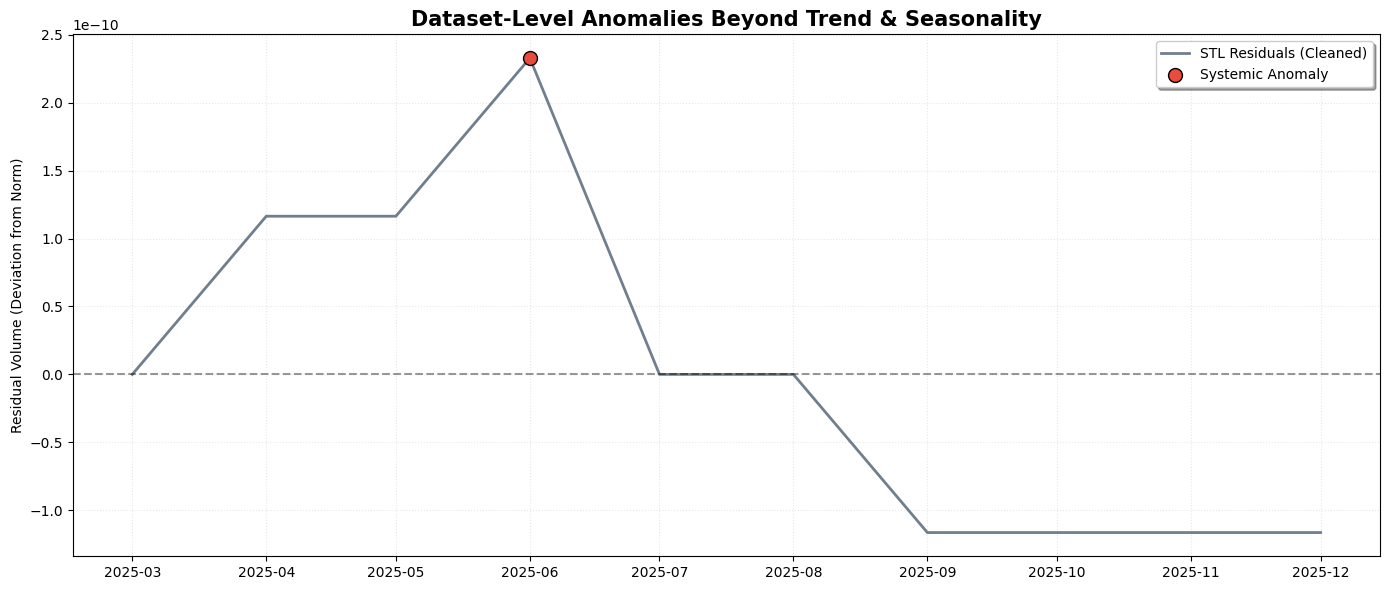

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
ts = enrol_monthly.set_index('ds')['y']
stl = STL(ts, period=12, robust=True).fit()
resid = stl.resid.dropna()
X_features = pd.DataFrame({
    'resid': resid,
    'abs_resid': np.abs(resid)
iso = IsolationForest(contamination=0.05, random_state=42)
X_features['anomaly'] = iso.fit_predict(X_features[['resid', 'abs_resid']])
plt.figure(figsize=(14,6))
plt.plot(X_features.index, X_features['resid'], label='STL Residuals (Cleaned)',
         linewidth=2, color='#34495e', alpha=0.7)
anomalies = X_features[X_features['anomaly'] == -1]
plt.scatter(
    anomalies.index,
    anomalies['resid'],
    color='#e74c3c',
    s=100,
    label='Systemic Anomaly',
    edgecolors='black',
    zorder=3
)

plt.axhline(0, color='black', linestyle='--', alpha=0.4)
plt.title('Dataset-Level Anomalies Beyond Trend & Seasonality', fontsize=15, fontweight='bold')
plt.ylabel('Residual Volume (Deviation from Norm)')
plt.legend(loc='best', frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

Anomaly Proportion

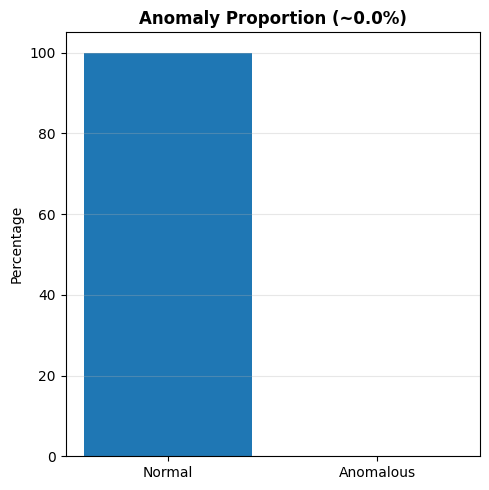

In [84]:
rate = (X['anomaly'] == -1).mean() * 100

plt.figure(figsize=(5,5))
plt.bar(['Normal', 'Anomalous'], [100-rate, rate])
plt.title(f'Anomaly Proportion (~{rate:.1f}%)', fontweight='bold')
plt.ylabel('Percentage')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [135]:
import matplotlib.pyplot as plt
import pandas as pd

X = X.copy()
X.index = pd.to_datetime(X.index)

cluster_df = X[X['anomaly'] == -1]

if cluster_df.empty:
    print("No temporal anomaly clusters detected in this period.")
else:
    monthly_clusters = (
        cluster_df
        .assign(month=cluster_df.index.to_period('M').astype(str))
        .groupby('month')
        .size()
    )
    plt.figure(figsize=(14,5))
    plt.plot(
        monthly_clusters.index,
        monthly_clusters.values,
        marker='o',
        linewidth=3
    )
    plt.title(
        'Temporal Clustering of Anomalies (Non-Random Behaviour)',
        fontsize=15,
        fontweight='bold'
    )
    plt.xlabel('Month')
    plt.ylabel('Number of Anomalies')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


No temporal anomaly clusters detected in this period.


In [93]:
print(df_enrol.columns)


Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
       'age_18_greater'],
      dtype='object')


In [94]:
enrol_monthly = (
    df_enrol
    .assign(date=pd.to_datetime(df_enrol['date']))
    .groupby(pd.Grouper(key='date', freq='MS'))[
        ['age_0_5', 'age_5_17', 'age_18_greater']
    ]
    .sum()
    .sum(axis=1)
    .reset_index()
)

enrol_monthly.columns = ['ds', 'y']


In [95]:
print(enrol_monthly.columns)


Index(['ds', 'y'], dtype='object')


In [96]:
from statsmodels.tsa.seasonal import STL

stl = STL(enrol_monthly['y'], period=12, robust=True)
res = stl.fit()

enrol_monthly['resid'] = res.resid


In [97]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    contamination=0.05,
    random_state=42
)

enrol_monthly['anomaly'] = iso.fit_predict(
    enrol_monthly[['resid']]
)


In [98]:
print(enrol_monthly.columns)


Index(['ds', 'y', 'resid', 'anomaly'], dtype='object')


In [99]:
enrol_anomalies = (
    enrol_monthly[['ds', 'anomaly']]
    .set_index('ds')['anomaly']
    .eq(-1)
    .astype(int)
)


In [101]:
demo_monthly = (
    df_demo
    .assign(date=pd.to_datetime(df_demo['date']))
    .groupby(pd.Grouper(key='date', freq='MS'))[
        ['demo_age_5_17', 'demo_age_17_']
    ]
    .sum()
    .sum(axis=1)
    .reset_index()
)

demo_monthly.columns = ['ds', 'y']


In [102]:
from statsmodels.tsa.seasonal import STL

stl_demo = STL(demo_monthly['y'], period=12, robust=True)
res_demo = stl_demo.fit()

demo_monthly['resid'] = res_demo.resid


In [103]:
from sklearn.ensemble import IsolationForest

iso_demo = IsolationForest(
    contamination=0.05,
    random_state=42
)

demo_monthly['anomaly'] = iso_demo.fit_predict(
    demo_monthly[['resid']]
)


In [104]:
print(demo_monthly.columns)


Index(['ds', 'y', 'resid', 'anomaly'], dtype='object')


In [105]:
demo_anomalies = (
    demo_monthly[['ds', 'anomaly']]
    .set_index('ds')['anomaly']
    .eq(-1)
    .astype(int)
)


In [106]:
demo_anomalies = (
    demo_monthly[['ds', 'anomaly']]
    .set_index('ds')['anomaly']
    .eq(-1)
    .astype(int)
)


In [107]:
import pandas as pd

bio_monthly = (
    df_bio
    .assign(date=pd.to_datetime(df_bio['date']))
    .groupby(pd.Grouper(key='date', freq='MS'))[
        ['bio_age_5_17', 'bio_age_17_']
    ]
    .sum()
    .sum(axis=1)
    .reset_index()
)

bio_monthly.columns = ['ds', 'y']


In [108]:
from statsmodels.tsa.seasonal import STL

stl_bio = STL(
    bio_monthly['y'],
    period=12,
    robust=True
)

res_bio = stl_bio.fit()

bio_monthly['trend']  = res_bio.trend
bio_monthly['season'] = res_bio.seasonal
bio_monthly['resid']  = res_bio.resid


In [109]:
from sklearn.ensemble import IsolationForest

iso_bio = IsolationForest(
    contamination=0.05,
    random_state=42
)

bio_monthly['anomaly'] = iso_bio.fit_predict(
    bio_monthly[['resid']]
)


In [110]:
bio_monthly[['ds', 'anomaly']].value_counts()


,,count
ds,anomaly,
2025-03-01,1,1
2025-04-01,1,1
2025-05-01,1,1
2025-06-01,1,1
2025-07-01,1,1
2025-08-01,1,1
2025-09-01,1,1
2025-10-01,1,1
2025-11-01,1,1


In [111]:
bio_anomalies = (
    bio_monthly[['ds', 'anomaly']]
    .set_index('ds')['anomaly']
    .eq(-1)
    .astype(int)
)


Cross-Dataset Anomaly overlap

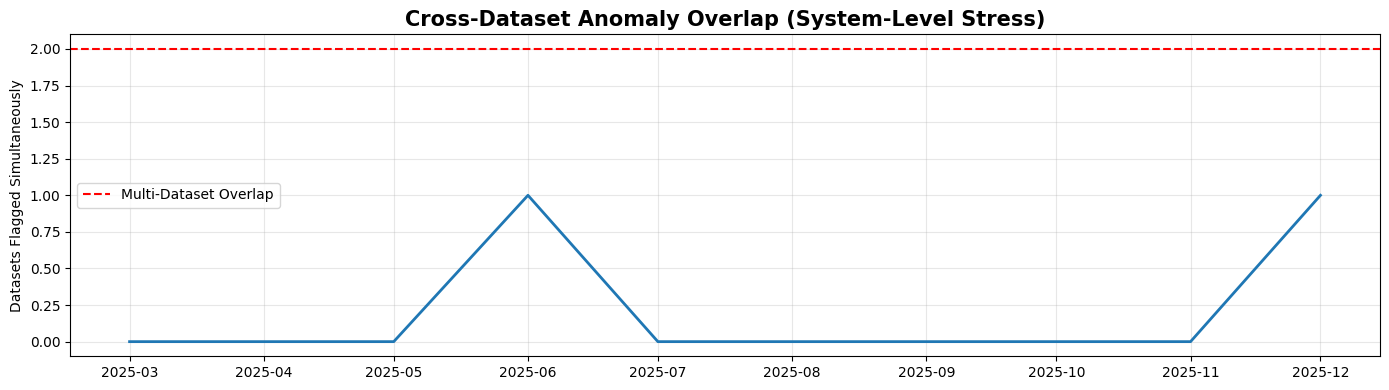

In [112]:
flags = pd.DataFrame({
    'enrol': enrol_anomalies,
    'demo': demo_anomalies,
    'bio': bio_anomalies
}).fillna(0)

overlap = flags.sum(axis=1)

plt.figure(figsize=(14,4))
plt.plot(overlap.index, overlap, linewidth=2)
plt.axhline(2, color='red', linestyle='--', label='Multi-Dataset Overlap')

plt.title(
    'Cross-Dataset Anomaly Overlap (System-Level Stress)',
    fontsize=15, fontweight='bold'
)
plt.ylabel('Datasets Flagged Simultaneously')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Aadhaar demand forecast

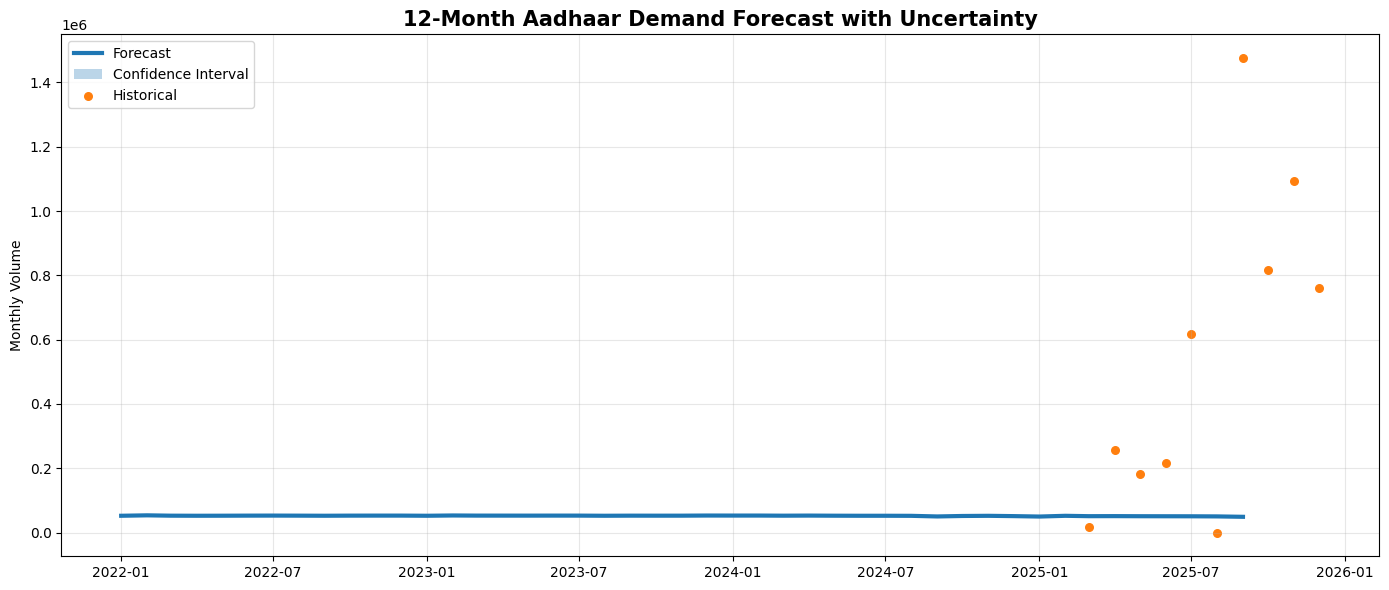

In [113]:
plt.figure(figsize=(14,6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linewidth=3)
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    alpha=0.3,
    label='Confidence Interval'
)
plt.scatter(enrol_monthly['ds'], enrol_monthly['y'], s=30, label='Historical')

plt.title(
    '12-Month Aadhaar Demand Forecast with Uncertainty',
    fontsize=15, fontweight='bold'
)
plt.ylabel('Monthly Volume')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Seasonal Demand Profile

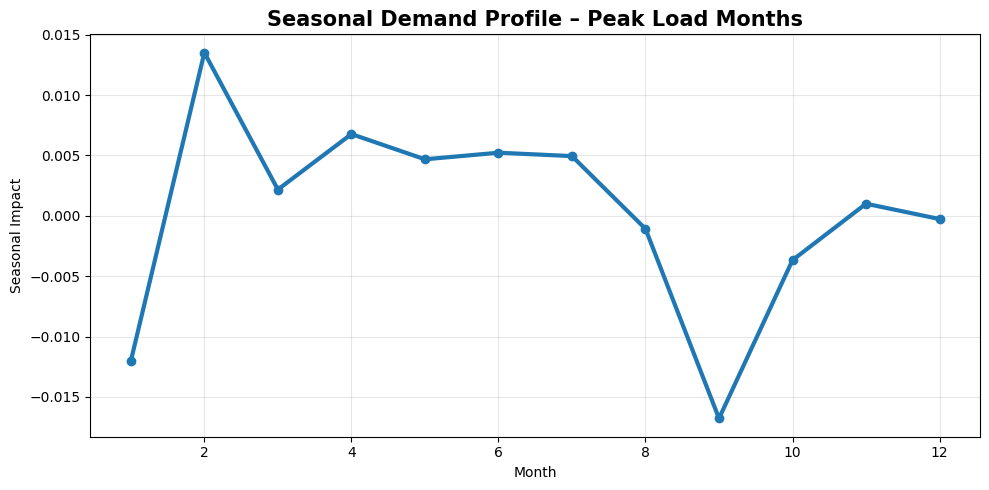

In [114]:
seasonal = forecast[['ds', 'yearly']].copy()
seasonal['month'] = seasonal['ds'].dt.month

monthly_seasonal = seasonal.groupby('month')['yearly'].mean()

plt.figure(figsize=(10,5))
monthly_seasonal.plot(marker='o', linewidth=3)

plt.title(
    'Seasonal Demand Profile – Peak Load Months',
    fontsize=15, fontweight='bold'
)
plt.xlabel('Month')
plt.ylabel('Seasonal Impact')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Forecast Uncertainty as operational Risk Indicator

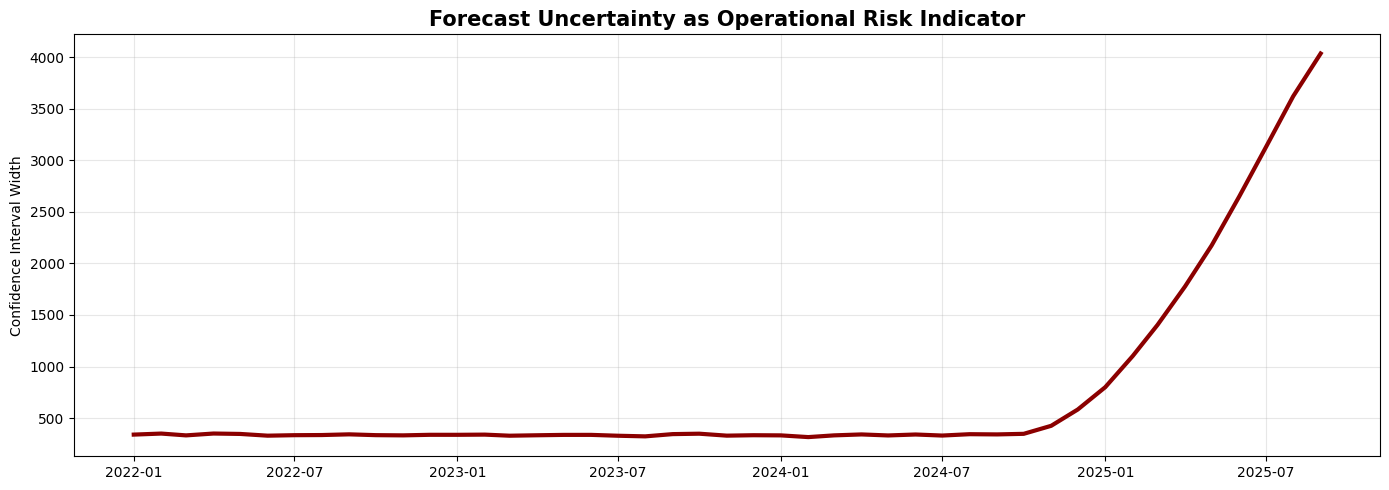

In [115]:
forecast['ci_width'] = forecast['yhat_upper'] - forecast['yhat_lower']

plt.figure(figsize=(14,5))
plt.plot(
    forecast['ds'],
    forecast['ci_width'],
    linewidth=3,
    color='darkred'
)

plt.title(
    'Forecast Uncertainty as Operational Risk Indicator',
    fontsize=15, fontweight='bold'
)
plt.ylabel('Confidence Interval Width')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
